<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #2 - Parte II: Aprendizaje Semi-Supervisado en NORB </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Septiembre 2016._

## Tabla de Contenidos
* [Aprendizaje Semi-Supervisado en NORB](#norb)
    * [Parte (a)](#a)
    * [Parte (b)](#b)
    * [Parte (c)](#c)
    * [Parte (d)](#d)
    * [Parte (e)](#e)

<div id='norb'/>
## Aprendizaje Semi-Supervisado en NORB

In [35]:
import os
import numpy as np
import pickle
import cPickle
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model, load_model, save_model, Sequential
from keras.optimizers import SGD
from keras.objectives import binary_crossentropy
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def unpickle(file):
    fo = open(file, 'rb')
    d = cPickle.load(fo)
    fo.close()
    return d

def show_results(acc_list, labels, title=None, loc=4):
    fig = plt.figure(figsize=(10,5))
    ax = fig.gca()
    x_axis = np.arange(0.0,1.01,0.1)
    ax.set_xticks(x_axis)
    plt.xlim(x_axis[0]-0.05, x_axis[-1]+0.05)
    if title is not None: plt.title(title)
    for i in range(len(acc_list)):
        plt.plot(x_axis[1:len(acc_list[i])+1], acc_list[i], 'o-', label=labels[i])
    plt.legend(loc=loc)
    plt.xlabel('$ \\theta = n_s/n_{tr}$')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

<div id='a'/>
### Parte (a)

Por diseño de implementación y utilidad (en cuanto al entrenamiento de las redes), se modificó la función inicial entregada `load_NORB_train_val`, para cargar sólo un batch, el cual es indicado en el argumento de la función.

In [15]:
def load_NORB_train_val(PATH, batch=1):
    f = os.path.join(PATH, 'data_batch_{0}'.format(batch))
    datadict = unpickle(f)
    X = datadict['data'].T
    Y = np.expand_dims(np.array(datadict['labels']), axis=1)
    Z = np.concatenate((X,Y),axis=1)
    np.random.shuffle(Z)
    return Z[5832:,0:-1], Z[5832:,-1],Z[:5832,0:-1], Z[:5832,-1]

def load_NORB_test(PATH):
    xt = []
    yt = []
    for b in range(11,13):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        datadict = unpickle(f)
        X = datadict['data'].T
        Y = np.expand_dims(np.array(datadict['labels']), axis=1)
        Z = np.concatenate((X,Y),axis=1)
        np.random.shuffle(Z)
        xt.append(Z[:,0:-1])
        yt.append(Z[:,-1])
    Xt   = np.concatenate(xt)
    Yt   = np.concatenate(yt)
    del xt,yt
    return Xt, Yt

In [7]:
X_train, y_train, X_val, y_val = load_NORB_train_val('data_part2/', batch=1)

In [17]:
X_test, y_test = load_NORB_test('data_part2/')

<div id='b'/>
### Parte (b)

La función que se presenta a continuación estandariza o escala los datos del array `X`. Por defecto (y en lo que sigue) se utilizará la estandarización (normal) como técnica de escalamiento de la data.

In [12]:
def data_transform(X, normalize=True, a=None, b=None):
    if normalize: return StandardScaler().fit_transform(X)
    else: return X*(b-a) + a  

<div id='c'/>
### Parte (c)

In [ ]:
def build_model(activation='relu'):
    model = Sequential()
    model.add(Dense(4000, input_dim=2048, activation=activation))
    model.add(Dense(2000, activation=activation))
    model.add(Dense(6, activation='softmax'))
    sgd = SGD(lr=0.1)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

La red utilizada en esta sección (y en las que siguen) es una MLP con dos capas ocultas de `4000` y `2000` unidades respectivamente, y función de activación `relu`. Debido a que el tiempo de entrenamiento para esta red es alto, se ha limitado el número de `epochs` a `10`. Adicionalmente se ha fijado el `batch_size` en `100` para hacer un uso más eficiente y buffer de memoria de la `GPU`.

El *loop* de a continuación es el encargado de simular el entrenamiento indicado. Dado que el conjunto de entrenamiento viene dividido en `10` partes iguales, para utilizar valores de $\theta \in [0.1, 0.2, \ldots, 1.]$, basta con ir cargando secuencialmente cada `data_batch`.

In [ ]:
acc_list = []
for i, theta in enumerate(np.linspace(0.1, 1., 10)):
    X_train, y_train, X_val, y_val = load_NORB_train_val('data_part2/', i+1)
    # scalling data
    X_train_scaled = data_transform(X_train)
    X_val_scaled = data_transform(X_val)
    # categorizing labels
    Y_train = np_utils.to_categorical(y_train, 6)
    Y_val = np_utils.to_categorical(y_val, 6)
    # model training
    model.fit(X_train_scaled, Y_train, batch_size=100, validation_data=(X_val_scaled, Y_val), nb_epoch=10)
    acc = model.evaluate(X_test_scaled, Y_test, verbose=0)
    acc_list.append(acc)

In [45]:
# loading results
base_dir = 'results-part2/'
res_mlp_relu = pickle.load( open(base_dir+'mlp_relu_acc') )

El gráfico siguiente muestra el `accuracy` en la medida que la red va *conociendo* más datos. De forma natura, este aumenta progresivamente (con un ligero salto en $\theta=0.8$), dado que al conocer más datos de entrenamiento, mejor es su capacidad de concocer el comportamiento verdadero del fenónemo.

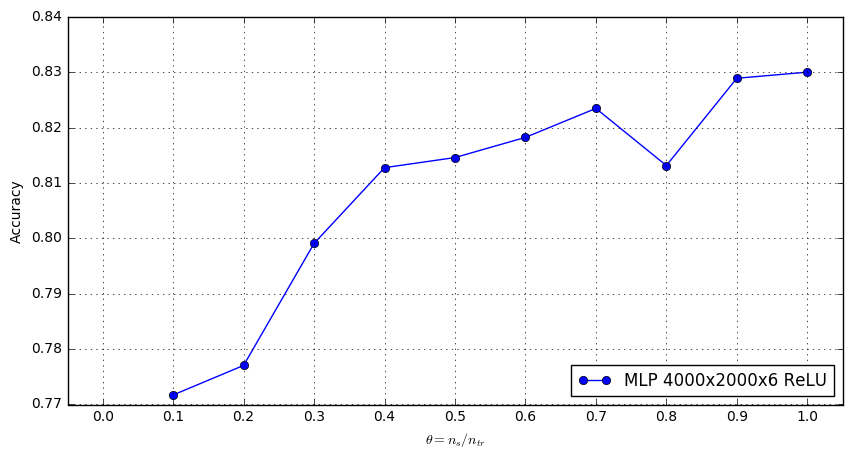

In [46]:
show_results( [np.array(res_mlp_relu)[:,1]] , ['MLP 4000x2000x6 ReLU'])

### Parte (d)

Para esta sección se ha decido realizar el pre-entrenamiento sobre los datos *no etiquetados* con AE y dAE. Para ambos se utilizó los mismos parámetros utilizados pa entrenar el MLP (*learning rate*, funciones de activación, función de pérdida). Para el dAE se eligió ruido gaussiano con `devst=0.1`, pues esa configuración mostró un buen desempeño en secciones anteriores.

In [47]:
# loading results
res_mlp_AE_relu = pickle.load( open(base_dir+'mlp_acc_AE_relu') )
res_mlp_DAE_relu = pickle.load( open(base_dir+'mlp_acc_DAE_relu') )

Se comparan a continuación las curvas de `accuracy` sobre el conjunto de prueba para las dos propuestas, más los resultados anteriores del MLP tradicional. Se aprecia de forma clara que pre-entrenar con los datos no etiquetados, le da la posibilidad a la red de alcanzar mejores resultados. Sin embargo el mejor resultado se obtienen con $\theta=0.9$, es decir, cuando se utilizan `10%` de los datos para pre-entrenar y el `90%` restante para el entrenamiento.

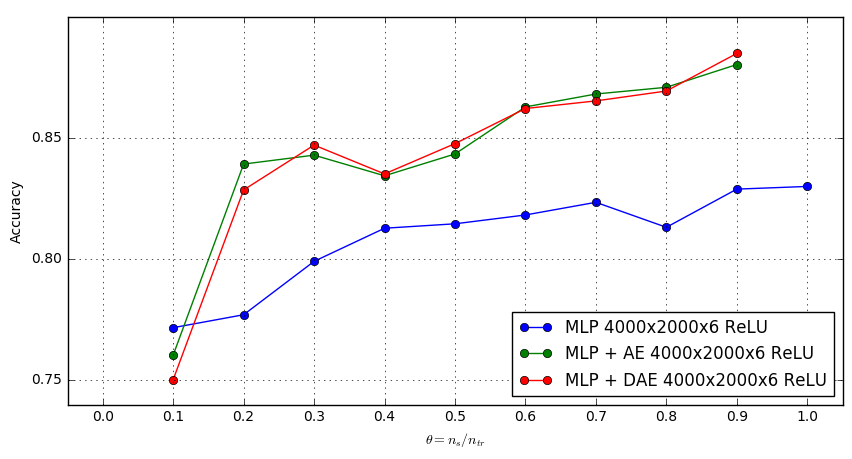

In [48]:
show_results( [np.array(res_mlp_relu)[:,1], np.array(res_mlp_AE_relu)[:,1], np.array(res_mlp_DAE_relu)[:,1]],
             ['MLP 4000x2000x6 ReLU', 'MLP + AE 4000x2000x6 ReLU', 'MLP + DAE 4000x2000x6 ReLU'])

**Nota**:  Para ver el código utilizado para entrenar las redes de esta parte y la siguiente (e), revisar los scripts `scripts_part2/mlp_semi_AE.py` y `scripts_part2/mlp_semi_DAE.py`.

### Parte (e)

Utilizando las mismas arquitecturas semi-supervisadas anteriores, se varían ahora las funciones de activación utilizadas.

In [49]:
# loading results
res_mlp_AE_sigmoid = pickle.load( open(base_dir+'mlp_acc_AE_sigmoid') )
res_mlp_DAE_sigmoid = pickle.load( open(base_dir+'mlp_acc_DAE_sigmoid') )
res_mlp_AE_tanh = pickle.load( open(base_dir+'mlp_acc_AE_tanh') )
res_mlp_DAE_tanh = pickle.load( open(base_dir+'mlp_acc_DAE_tanh') )

El gráfico siguiente compara la arquitectura `MLP + AE` con las tres funciones de activación. Claramente la que tiene un mejor desempeño es `tanh`, favoreciendo el proceso de pre-entrenamiento como el de entrenamiento. Es importante notar que la mejor `accuracy` se obtiene en $\theta=0.8$.

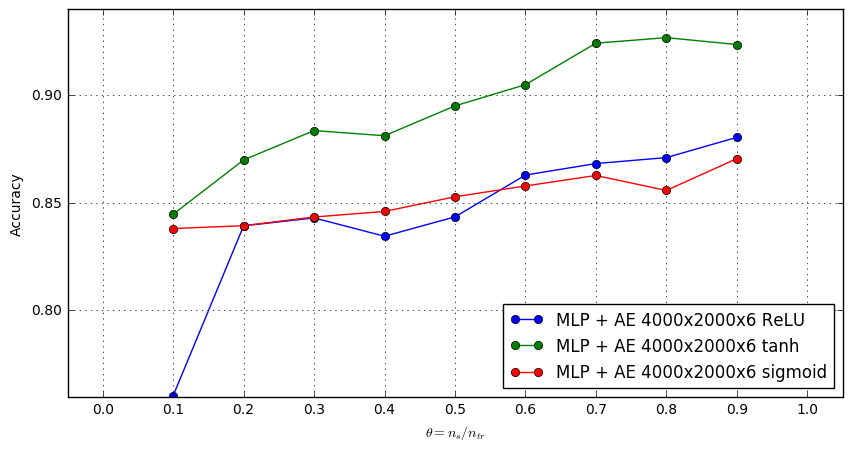

In [50]:
show_results( [np.array(res_mlp_AE_relu)[:,1], np.array(res_mlp_AE_tanh)[:,1], np.array(res_mlp_AE_sigmoid)[:,1]],
             ['MLP + AE 4000x2000x6 ReLU', 'MLP + AE 4000x2000x6 tanh', 'MLP + AE 4000x2000x6 sigmoid'])

De modo análogo se hace la comparación para `MLP + DAE`. Aca los resultados están más parejos, excepto que con `relu` para $\theta \leq 0.2$ hay `accuracy` bajo. De todas formas, ninguna de estas configuraciones logra superar al `MLP + AE` con activación `tanh`.

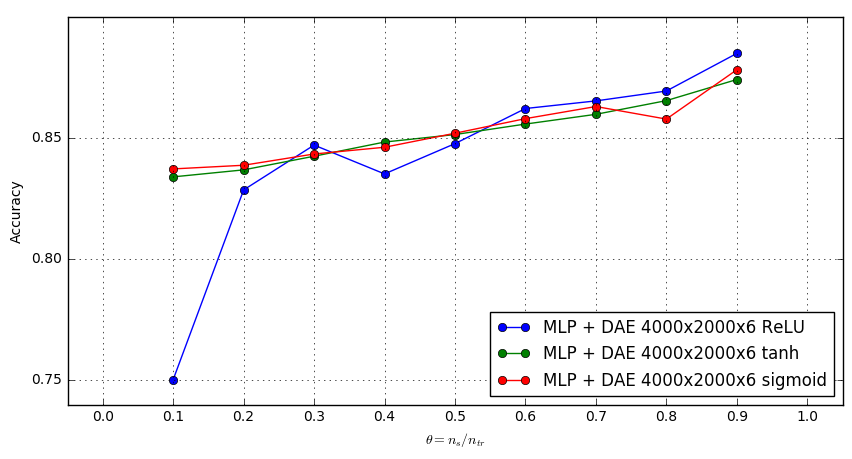

In [51]:
show_results( [np.array(res_mlp_DAE_relu)[:,1], np.array(res_mlp_DAE_tanh)[:,1], np.array(res_mlp_DAE_sigmoid)[:,1]],
             ['MLP + DAE 4000x2000x6 ReLU', 'MLP + DAE 4000x2000x6 tanh', 'MLP + DAE 4000x2000x6 sigmoid'])